<a href="https://colab.research.google.com/github/sombr3ro/Machine-Learning-Repo/blob/main/Machine-Learning-Repo/Transfer-Learning-vgg/VGG_small_fruit_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
os.chdir('/content/drive/My Drive/code/')
print(os.getcwd())

/content/drive/My Drive/code


In [ ]:
import torch
from fruit_360_small_dataset import fruit_360_small
import matplotlib.pyplot as plt 
from torch.utils.data import DataLoader
from torchvision.models import vgg16 
from torchvision import transforms
import numpy as np 
from torch import nn

In [ ]:
transform = transforms.Compose([
    transforms.Normalize(mean=0.0,std =255.0),
    transforms.Resize(300),
    ])

In [ ]:
train_dat =fruit_360_small("./Datasets/fruit-360-small/new",train = True, transform = transform)
test_dat = fruit_360_small("./Datasets/fruit-360-small/new",train = False, transform = transform)

In [ ]:
#train_dat[2][0].shape

In [ ]:
class_labels = train_dat.class_labels
print(class_labels)

['Watermelon', 'Raspberry']


In [ ]:
batch_size = 64
train_load = DataLoader(train_dat, shuffle=True, batch_size = batch_size)
test_load = DataLoader(test_dat, shuffle=True, batch_size = batch_size)

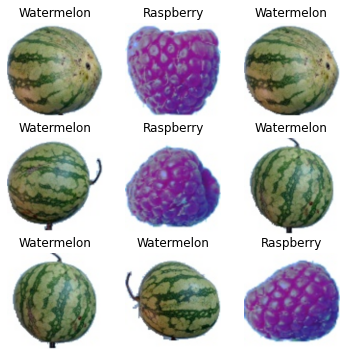

In [ ]:
rows = 3
cols = 3
fig,axs = plt.subplots(rows,cols, figsize=(6,6))

for i in range(rows):
    for j in range(cols):
        ax = axs[i,j]
        idx = np.random.randint(len(train_dat))
        img,label = train_dat[idx]
        img = img.permute(1,2,0)
        ax.set_title(class_labels[label])
        ax.axis("off")
        ax.imshow(img)

In [ ]:
device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device 

device(type='cuda')

In [ ]:
model = vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [ ]:
model = model.to(device)

In [ ]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
for params in model.parameters():
    params.require_grad = False
model.classifier._modules['6'] = nn.Linear(4096,2)
model = model.to(device)

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters())

In [ ]:
def train(train_load, model, loss_fn, optim, size):
    total_loss = 0.0
    total_acc = 0.0
    
    for batch,(x,y) in enumerate(train_load):
        x = x.to(device)
        y = y.to(device)
        pred = model(x)

        loss = loss_fn(pred,y)

        total_loss+=loss.item()
        total_acc+= (pred.argmax(1)==y).sum().item()

        print(f"{batch+1}th batch: Training loss: {total_loss}")

        optim.zero_grad()
        loss.backward()
        optim.step()

    total_loss/=size
    total_acc = total_acc/size*100
    return total_loss, total_acc

In [ ]:
def test(test_load, model, loss_fn, size):
    total_loss = 0.0
    total_acc = 0.0

    model.eval()
    with torch.no_grad():
        for (x,y) in test_load:
            x = x.to(device)
            y = y.to(device)
            pred = model(x)

            loss = loss_fn(pred,y)

            total_loss+=loss.item()
            total_acc+= (pred.argmax(1)==y).sum().item()
    
    total_loss/=size
    total_acc = total_acc/size*100
    return total_loss, total_acc

In [ ]:
epoch = 10 
train_loss = []
train_acc=[]
test_loss = []
test_acc = []
train_size = len(train_dat)
test_size = len(test_dat)

for e in range(1,epoch+1):

    print(f"Epoch {e} begins-------------------")
    loss,acc = train(train_load, model, loss_fn, optim, train_size)
    print(f"\n Training Loss {loss} \t Training Accuracy {acc}")
    train_loss.append(loss)
    train_acc.append(acc)

    loss,acc = test(test_load, model, loss_fn, test_size)
    print(f"\n Test Loss {loss} \t Test Accuracy {acc}")
    test_loss.append(loss)
    test_acc.append(acc)
print("Done-----------------")

Epoch 1 begins-------------------
1th batch: Training loss: 1.4063782691955566
2th batch: Training loss: 2.4842952489852905
3th batch: Training loss: 5.140051245689392
4th batch: Training loss: 5.856327831745148
5th batch: Training loss: 6.651797592639923
6th batch: Training loss: 7.363950431346893
7th batch: Training loss: 8.048882782459259
8th batch: Training loss: 8.983259677886963
9th batch: Training loss: 9.677188396453857
10th batch: Training loss: 10.375656187534332
11th batch: Training loss: 11.033535122871399
12th batch: Training loss: 13.093004584312439
13th batch: Training loss: 13.7842538356781
14th batch: Training loss: 14.406696021556854
15th batch: Training loss: 15.153424084186554
16th batch: Training loss: 15.890133082866669

 Training Loss 0.01646645915322971 	 Training Accuracy 48.80829015544042

 Test Loss 0.008633682602330259 	 Test Accuracy 51.39318885448917
Epoch 2 begins-------------------
1th batch: Training loss: 0.4680482745170593
2th batch: Training loss: 1.

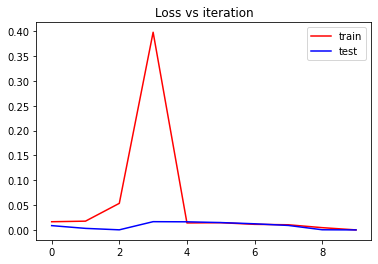

In [ ]:
plt.title("Loss vs iteration")
plt.plot(train_loss, 'r', label = 'train')
plt.plot(test_loss, 'b', label = 'test')
plt.legend()

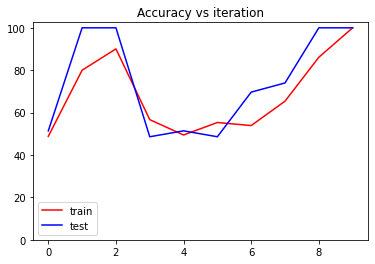

In [ ]:
plt.title("Accuracy vs iteration")
plt.plot(train_acc, 'r', label = 'train')
plt.plot(test_acc, 'b', label = 'test')
plt.ylim(ymin=0)
plt.legend()

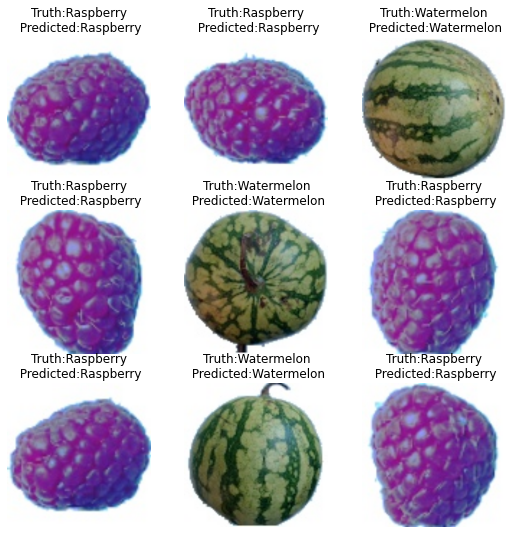

In [ ]:
rows = 3
cols = 3
fig,axs = plt.subplots(rows,cols,figsize=(9,9))

for i in range(rows):
  for j in range(cols):
    ax = axs[i,j]
    idx = np.random.randint(len(test_dat))
    img,label = test_dat[idx]

    model.eval()
    with torch.no_grad():
      x = img.to(device).unsqueeze(0)
      pred = model(x).argmax()
    
    truth_label = class_labels[label]
    pred_label = class_labels[label]
    img = img.permute(1,2,0)
    ax.axis('off')
    ax.imshow(img)
    ax.set_title(f"Truth:{truth_label}\n Predicted:{pred_label}")